# Imports and Mount

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Dataset creation

In [ ]:
!unzip /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Dataset/Training.zip > logs.txt

In [ ]:
bokeh_GT = "/content/bokeh/"
bokeh_Original = "/content/original/"

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor

  image = tf.io.read_file(image_file)
  input_image = tf.io.decode_jpeg(image)

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)

  return input_image

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image

In [ ]:
def load_image_train(image_file):
  input_image = load(image_file)
  input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
  input_image = random_jitter(input_image)
  input_image = normalize(input_image)

  return input_image

In [ ]:
train_dataset_original = tf.data.Dataset.list_files(str(bokeh_Original + '*.jpg'))
train_dataset_original = train_dataset_original.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_original = train_dataset_original.shuffle(BUFFER_SIZE)
train_dataset_original = train_dataset_original.batch(BATCH_SIZE)

In [ ]:
train_dataset_bokeh = tf.data.Dataset.list_files(str(bokeh_GT + '*.jpg'))
train_dataset_bokeh = train_dataset_bokeh.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_bokeh = train_dataset_bokeh.shuffle(BUFFER_SIZE)
train_dataset_bokeh = train_dataset_bokeh.batch(BATCH_SIZE)

In [ ]:
sample_orig = next(iter(train_dataset_original))
sample_bokeh = next(iter(train_dataset_bokeh))

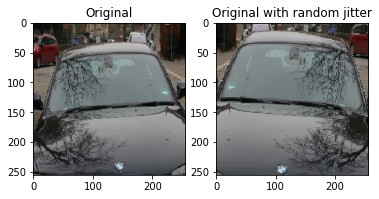

In [ ]:
plt.subplot(121)
plt.title('Original')
plt.imshow(sample_orig[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Original with random jitter')
plt.imshow(random_jitter(sample_orig[0]) * 0.5 + 0.5)

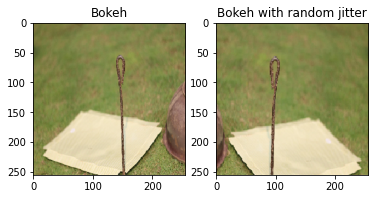

In [ ]:
plt.subplot(121)
plt.title('Bokeh')
plt.imshow(sample_bokeh[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Bokeh with random jitter')
plt.imshow(random_jitter(sample_bokeh[0]) * 0.5 + 0.5)

#Import and reuse the Pix2Pix models

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

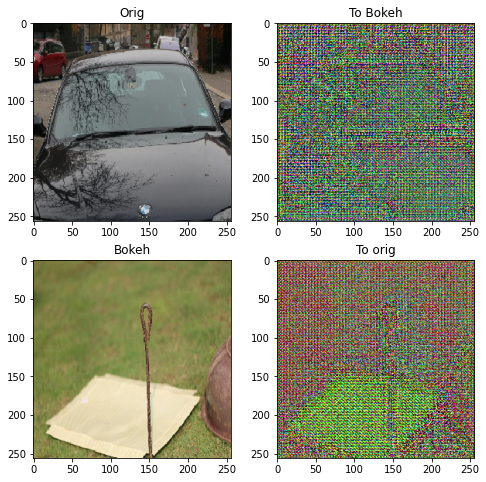

In [ ]:
to_bokeh = generator_g(sample_orig)
to_orig = generator_f(sample_bokeh)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_orig, to_bokeh, sample_bokeh, to_orig]
title = ['Orig', 'To Bokeh', 'Bokeh', 'To orig']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

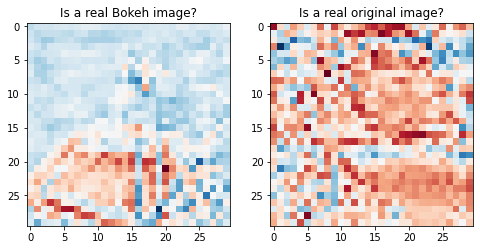

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Bokeh image?')
plt.imshow(discriminator_y(sample_bokeh)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real original image?')
plt.imshow(discriminator_x(sample_orig)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss functions and optimizers

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints creation and restore

In [ ]:
checkpoint_path = "/content/drive/Shareddrives/DeepLearning_VisionAnalytics/saved_models/cycleGAN/tf_cycleGAN/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

In [ ]:
EPOCHS = 10

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_dataset_original, train_dataset_bokeh)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_orig) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_orig)

  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

#Inference

In [ ]:
bokeh_GT = "/content/bokeh/"
bokeh_Original = "/content/original/"
outputdir = "/content/drive/Shareddrives/DeepLearning_VisionAnalytics/saved_models/cycleGAN/Images/"

In [ ]:
from skimage.transform import resize
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG

In [ ]:
if not os.path.exists(outputdir):
    os.mkdir(outputdir)

for i in range(100):
    img = bokeh_Original + str(i) + ".jpg"
    out_name = os.path.basename(img)
    orginal_img = np.array(Image.open(img))
    orginal_img_resized = np.expand_dims(resize(orginal_img, (256, 256, 3)), 0)

    #generate_images_and_save(generator, orginal_img_resized)
    gen_output = generator_g(orginal_img_resized, training=True)
    gen_output = gen_output[0] #* 0.5 + 0.5

    im = Image.fromarray((gen_output.numpy() * 255).astype(np.uint8))
    im.save(os.path.join(outputdir, out_name), subsampling=0, quality=100)
    
    plt.figure(figsize=(9, 9))
    display_list = [orginal_img_resized[0], gen_output]
    title = ['Input Image', 'Predicted Image']

    plt.imshow(gen_output)# * 0.5 + 0.5)
    plt.axis('off')
    plt.savefig(os.path.join(outputdir, out_name), bbox_inches='tight', pad_inches = 0)
    plt.show()
    print('processing:',i+1, '/100, save img:',os.path.join(outputdir, out_name))
print('processed')

Output hidden; open in https://colab.research.google.com to view.

#Evaluation

##PSNR

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
from skimage.transform import resize
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
values = []
for i in range(100):
  img1 = bokeh_GT + str(i) + ".jpg"
  img2 = outputdir + str(i) + ".jpg"

  generated_bokeh = cv2.imread(img2)
  ground_truth_bokeh = resize(cv2.imread(img1), (generated_bokeh.shape[0], generated_bokeh.shape[1], 3))
  ground_truth_bokeh *= (255.0/ground_truth_bokeh.max())
    
  values.append(PSNR(ground_truth_bokeh, generated_bokeh))
values = np.array(values)
print(f"Avg PSNR value is {np.average(values)}")

Avg PSNR value is 21.545428830936263


## SSIM

In [ ]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
values = []
for i in range(100):
  img1 = bokeh_GT + str(i) + ".jpg"
  img2 = outputdir + str(i) + ".jpg"

  generated_bokeh = cv2.imread(img2)
  ground_truth_bokeh = resize(cv2.imread(img1), (generated_bokeh.shape[0], generated_bokeh.shape[1], 3))
  ground_truth_bokeh *= (255.0/ground_truth_bokeh.max())
  values.append(calculate_ssim(ground_truth_bokeh, generated_bokeh))
values = np.array(values)
print(f"Avg SSIM value is {np.average(values)}")

Avg SSIM value is 0.7418894450790386
